In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from wordcloud import WordCloud, STOPWORDS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_phish = pd.read_csv("/content/drive/MyDrive/ProjetData354/Projet1/fishing-train.csv")

In [ ]:
df_phish.head(5)

,url,label
0,http://mylust.com/videos/198456/svelte-nympho-...,legit
1,http://serverfault.com/questions/676825/basic-...,legit
2,http://otomoto.pl/osobowe/bmw/seria-3/e36-1990...,legit
3,http://motthegioi.vn/khoa-hoc-giao-duc/du-hoc/...,legit
4,https://att-yahoo-mail-2023.weeblysite.com/,fishing


# Analyse des données

In [ ]:
# Afficher le nombre de lignes et de colonnes de mon dataset
df_phish.shape

(23523, 2)

In [ ]:
# Afficher les dernières lignes du DataFrame
df_phish.tail()

,url,label
23518,http://buzzfil.net/article/5285/c-mignon/ce-ch...,legit
23519,http://kenh14.vn/doi-song/trao-luu-luon-song-c...,legit
23520,http://abcnews.go.com/US/wireStory/exterminato...,legit
23521,http://thenextweb.com/apps/2015/05/07/massive-...,legit
23522,http://themeforest.net/item/mist-30-business-e...,legit


In [ ]:
# renvoyer le décompte du nombre d'occurrences de chaque valeur unique dans la colonne 'label' du DataFrame
df_phish.label.value_counts()

legit      17688
fishing     5835
Name: label, dtype: int64

In [ ]:
# Afficher les colonnes
df_phish.columns

Index(['url', 'label'], dtype='object')

In [ ]:
# Information sur le DataFrame
df_phish.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23523 entries, 0 to 23522
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     23523 non-null  object
 1   label   23523 non-null  object
dtypes: object(2)
memory usage: 367.7+ KB


À propos de l'ensemble de données nous avons 23523 entrées uniques.
Il y a deux colonnes, la colonne d'étiquette est une colonne de prédiction qui donc 2 catégories:
- `legit`, ce qui signifie que les URL ne contiennent pas d'éléments malveillants et que ce site n'est pas un phishing.

- `fishing` , ce qui signifie que les URL contiennent des éléments malveillants et que ce site est un site de phishing.

Il n'y a aucune valeur manquante dans l'ensemble de données.

In [ ]:
# compter le nombre de valeurs nulles dans chaque colonne du DataFrame
df_phish.isnull().sum()

url      0
label    0
dtype: int64

In [ ]:
# compter le nombre de valeurs dupliquées dans la colonne "url" du DataFrame.
df_phish.url.duplicated().sum()

0

<Axes: >

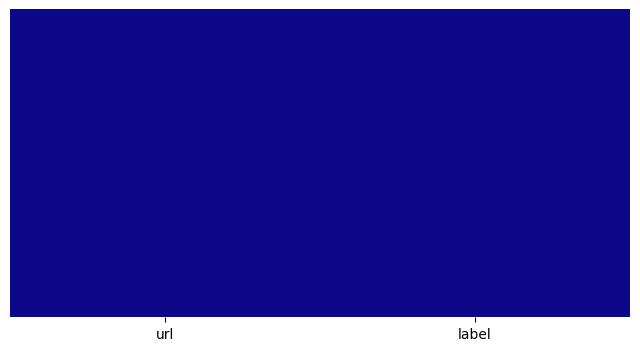

In [ ]:
# Créer une figure avec une taille de 8x4 pouces
plt.figure(figsize=(8, 4))

# Créer une carte thermique (heatmap) pour visualiser les valeurs nulles dans le DataFrame df_phish
# yticklabels=False : Ne pas afficher les étiquettes sur l'axe des y
# cbar=False : Ne pas afficher la barre de couleur sur le côté
# cmap='plasma' : Utiliser la palette de couleurs 'plasma'
sns.heatmap(df_phish.isnull(), yticklabels=False, cbar=False, cmap='plasma')


In [ ]:
# Affiche les statistiques descriptives du DataFrame df_phish
df_phish.describe()

,url,label
count,23523,23523
unique,23523,2
top,http://mylust.com/videos/198456/svelte-nympho-...,legit
freq,1,17688


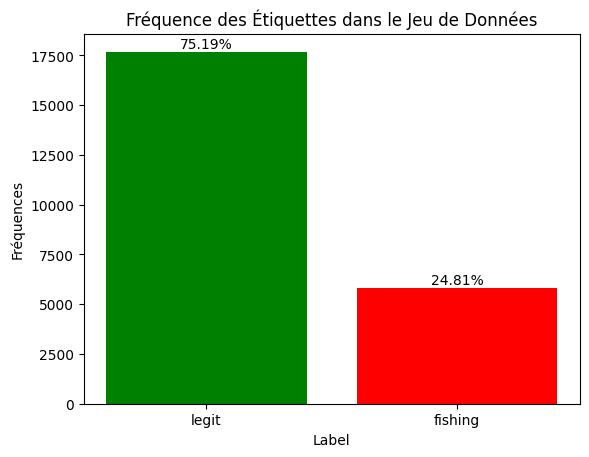

In [ ]:
# Extraction de la colonne des étiquettes du DataFrame
labels = df_phish.label

# Création d'un nouveau DataFrame à partir de la colonne des étiquettes
labels = pd.DataFrame(labels)

# Calcul de la fréquence et du pourcentage des différentes étiquettes
labels_count = labels["label"].value_counts()
labels_percentage = labels_count / len(labels) * 100

# Affichage de la fréquence des étiquettes sous forme de diagramme à barres avec le pourcentage
fig, ax = plt.subplots()
bars = ax.bar(labels_count.index, labels_count.values, color=['green', 'red'])

# Ajout des étiquettes de pourcentage au-dessus des barres
for bar, percentage in zip(bars, labels_percentage):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.2f}%',
            ha='center', va='bottom', fontsize=10, color='black')

# Configuration du diagramme
ax.set_xlabel("Label")  # Axe des x : Étiquettes
ax.set_ylabel("Fréquences")  # Axe des y : Fréquences
ax.set_title("Fréquence des Étiquettes dans le Jeu de Données")  # Titre du diagramme
plt.show()

### Remplacer les étiquettes

In [ ]:
df_phish.replace({'legit':0, 'fishing':1}, inplace=True)

# Prétraitement

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

# Télécharger les stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

La fonction `preprocess_initial` effectue la tokenization et la racinisation initiales sur une URL. Elle utilise un tokenizer pour diviser l'URL en mots, un stemmer pour réduire les mots à leur racine, et elle supprime ensuite les stopwords spécifiques aux URL. Enfin, elle concatène les mots résultants pour former une version traitée de l'URL.

In [ ]:
def preprocess_initial(url):
    """
    Fonction pour effectuer la tokenization et la racinisation initiales sur une URL.

    Parameters:
    - url: URL à traiter.

    Returns:
    - Texte tokenisé et racinisé.
    """

    # Créer le tokenizer
    tokenizer = RegexpTokenizer(r'[A-Za-z]+')

    # Appliquer la tokenization à l'URL
    text_tokenise = tokenizer.tokenize(url)

    # Créer le stemmer
    stemmer = SnowballStemmer("english")

    # Appliquer la racinisation à l'URL
    text_stemmed = [stemmer.stem(word) for word in text_tokenise]

    # Enlever les stopwords spécifiques aux URL
    url_specific_stopwords = set(stopwords.words('english') + ['www', 'http', 'https', 'com', 'org', 'net', 'html', 'php','cf', 'ipf'])
    text_stemmed = [word for word in text_stemmed if word.lower() not in url_specific_stopwords]

    # Appliquer la concaténation
    text_sent = ' '.join(text_stemmed)

    return text_sent

Le code ci-dessous crée un nouveau DataFrame appelé `df_phish_processed` et y ajoute les colonnes 'url' et 'label' du DataFrame d'origine `df_phish`. Ensuite, il applique la fonction `preprocess_initial` à la colonne 'url' du DataFrame d'origine pour créer une nouvelle colonne 'text_sent' dans le DataFrame `df_phish_processed`, qui contient les URLs prétraitées.

In [ ]:
# Créez un nouveau DataFrame vide
df_phish_processed = pd.DataFrame()

# Ajoutez la colonne 'url' à partir de notre DataFrame d'origine
df_phish_processed['url'] = df_phish['url']

# Ajoutez la colonne 'label' à partir de votre DataFrame d'origine
df_phish_processed['label'] = df_phish['label']

# Appliquez la fonction preprocess_initial à la colonne 'url' pour créer la nouvelle colonne 'text_sent'
df_phish_processed['text_sent'] = df_phish['url'].apply(preprocess_initial)

In [ ]:
# afficher les cinq premières lignes du DataFrame df_phish_processed.
df_phish_processed.head(5)

,url,label,text_sent
0,http://mylust.com/videos/198456/svelte-nympho-...,0,mylust video svelt nympho ride lover prick fav...
1,http://serverfault.com/questions/676825/basic-...,0,serverfault question basic ncsa authent workl ...
2,http://otomoto.pl/osobowe/bmw/seria-3/e36-1990...,0,otomoto pl osobow bmw seria e sportowi coup ew...
3,http://motthegioi.vn/khoa-hoc-giao-duc/du-hoc/...,0,motthegioi vn khoa hoc giao duc du hoc nhung d...
4,https://att-yahoo-mail-2023.weeblysite.com/,1,att yahoo mail weeblysit


Regardons si nous avons le résulat escompté

In [ ]:
print(df_phish['url'].head(3))

'http://mylust.com/videos/198456/svelte-nympho-rides-her-lover-s-prick-in-her-favorite-cowgirl-position/'

In [ ]:
df_phish_processed['text_sent'].head(3)

'mylust video svelt nympho ride lover prick favorit cowgirl posit'

crée un nouveau DataFrame appelé bad_sites, qui contient uniquement les lignes du DataFrame original df_phish_processed où la colonne 'label' a la valeur 1.
Cela sera utile pour la visualisation de nos URLs pretraitées, voir s'il n'y pas de stopwords

In [ ]:
bad_sites = df_phish_processed[df_phish_processed.label == 1]

In [ ]:
bad_sites.head(3)

,url,label,text_sent
4,https://att-yahoo-mail-2023.weeblysite.com/,1,att yahoo mail weeblysit
8,https://new.express.adobe.com/webpage/kz4V6Dar...,1,new express adob webpag kz v darbjh v
14,http://vpn287980672.softether.net/~pc119/ANZ/a...,1,vpn softeth pc anz apib anzapinetbank htm


ce code permet de visualiser les mots les plus fréquents dans les URLs des sites de phishing sous forme d'un nuage de mots. Etant donné que nous avons déjà pretraité les données l'on de devrait pas avoir de stopwods.

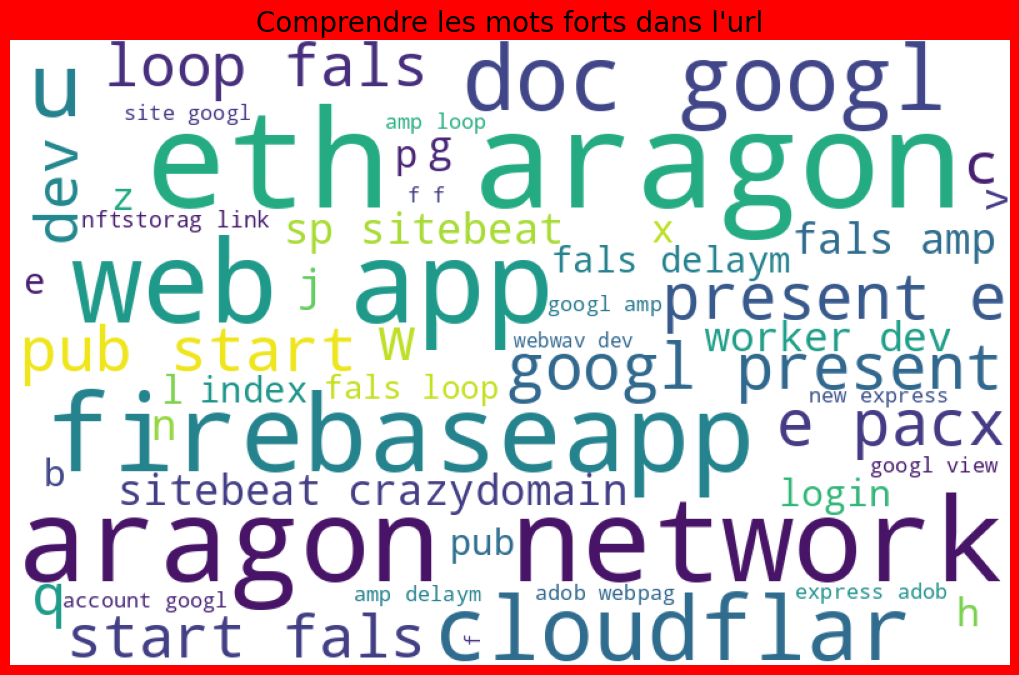

In [ ]:

phishing = bad_sites['text_sent']

# Création d'un objet WordCloud avec des paramètres spécifiés
phishing_cloud = WordCloud(
    width=800, height=500, background_color='white', max_words=50
).generate(' '.join(phishing))

# Configuration de la taille de la figure du graphique et de la couleur de fond
plt.figure(figsize=(10, 8), facecolor='r')

# Affichage de l'image WordCloud
plt.imshow(phishing_cloud)

# Ajout d'un titre au graphique
plt.title("Comprendre les mots forts dans l'url", fontsize=20)

# Désactivation des étiquettes des axes
plt.axis('off')

# Ajustement de la mise en page pour une meilleure apparence
plt.tight_layout(pad=0)

# Affichage du graphique
plt.show()

## Vectoriser les données

In [ ]:
# Créer une instance du vectoriseur TF-IDF
vectorizer = TfidfVectorizer()

In [ ]:

# Appliquer le vectoriseur aux données textuelles de la colonne 'text_sent'
feature = vectorizer.fit_transform(df_phish_processed['text_sent'])

In [ ]:
# Afficher la forme de la matrice TF-IDF
print("Forme de la matrice TF-IDF :", feature.shape)

# Tester et évaluer les modèles

In [ ]:
# Define report generator

def generer_rapport(matrice_confusion, score, rapport_classification):
    """
    Génère et affiche des rapports graphiques
    Arguments par mot-clé :
        matrice_confusion - Matrice de confusion générée par le modèle
        score --- Score généré par le modèle
        rapport_classification - Rapport de classification généré par le modèle

    """

    # Générer la carte thermique de la matrice de confusion
    plt.figure(figsize=(5, 5))
    sns.heatmap(matrice_confusion,
                annot=True,
                fmt="d",
                linewidths=.5,
                square=True,
                cmap='viridis',
                annot_kws={"size": 13},
                xticklabels=['fishing', 'legit'],
                yticklabels=['fishing', 'legit'])

    plt.xticks(rotation='horizontal', fontsize=13)
    plt.yticks(rotation='horizontal', fontsize=13)
    plt.xlabel('Étiquette Réelle', size=10);
    plt.ylabel('Étiquette Prédite', size=10);

    titre = 'Score de Précision : {0:.4f}'.format(score)
    plt.title(titre, size=15);

    # Afficher le rapport de classification et la matrice de confusion
    print(rapport_classification)
    plt.show()


## Importation des modèles

In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB  # Ajout de l'import pour Naive Bayes multinomial
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Multinomial Naive Bayesian with TF-IDF

# Train the model
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(tfidf_train, labels)


# Test the mode (score, predictions, confusion matrix, classification report)
score_mnb_tfidf = mnb_tfidf.score(tfidf_test, test_labels)
predictions_mnb_tfidf = mnb_tfidf.predict(tfidf_test)
cmatrix_mnb_tfidf = confusion_matrix(predictions_mnb_tfidf, test_labels)
creport_mnb_tfidf = classification_report(predictions_mnb_tfidf, test_labels)

Evaluation
              precision    recall  f1-score   support

           0       1.00      0.77      0.87      4537
           1       0.14      0.96      0.24       168

    accuracy                           0.78      4705
   macro avg       0.57      0.87      0.56      4705
weighted avg       0.97      0.78      0.85      4705



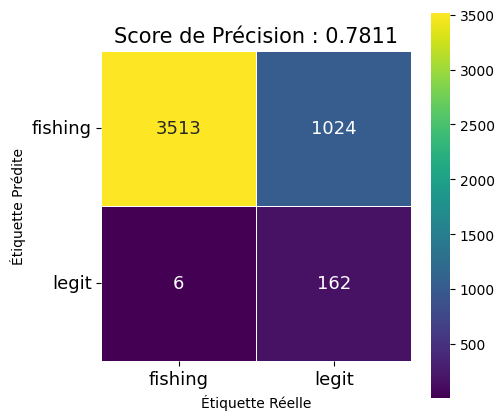

In [ ]:
print("Evaluation")
generer_rapport(cmatrix_mnb_tfidf, score_mnb_tfidf, creport_mnb_tfidf)

In [ ]:
# Multinomial Naive Bayesian with TF-IDF

# Train the model
LR_tfidf = LogisticRegression()
LR_tfidf.fit(tfidf_train, labels)


# Test the mode (score, predictions, confusion matrix, classification report)
score_LR_tfidf = LR_tfidf.score(tfidf_test, test_labels)
predictions_LR_tfidf = LR_tfidf.predict(tfidf_test)
cmatrix_LR_tfidf = confusion_matrix(predictions_LR_tfidf, test_labels)
creport_LR_tfidf = classification_report(predictions_LR_tfidf, test_labels)

Evaluation
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      3716
           1       0.77      0.92      0.84       989

    accuracy                           0.93      4705
   macro avg       0.87      0.93      0.90      4705
weighted avg       0.93      0.93      0.93      4705



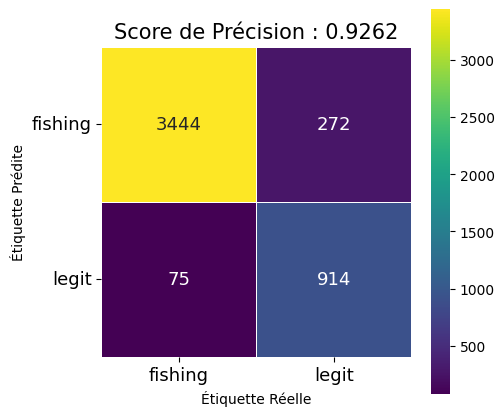

In [ ]:
print("Evaluation")
generer_rapport(cmatrix_LR_tfidf, score_LR_tfidf, creport_LR_tfidf)

In [ ]:
# Train the model
RF_tfidf = RandomForestClassifier()
RF_tfidf.fit(tfidf_train, labels)


# Test the mode (score, predictions, confusion matrix, classification report)
score_RF_tfidf = RF_tfidf.score(tfidf_test, test_labels)
predictions_RF_tfidf = RF_tfidf.predict(tfidf_test)
cmatrix_RF_tfidf = confusion_matrix(predictions_RF_tfidf, test_labels)
creport_RF_tfidf = classification_report(predictions_RF_tfidf, test_labels)

Evaluation
              precision    recall  f1-score   support

     fishing       0.89      0.97      0.93      1086
       legit       0.99      0.96      0.98      3619

    accuracy                           0.96      4705
   macro avg       0.94      0.97      0.95      4705
weighted avg       0.97      0.96      0.97      4705



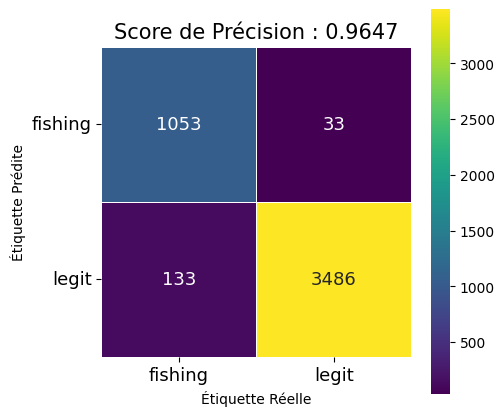

In [ ]:
print("Evaluation")
generer_rapport(cmatrix_RF_tfidf, score_RF_tfidf, creport_RF_tfidf)

## Evaluation sur de nouvelles données

In [ ]:
predict_good = ['youtube.com/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']

In [ ]:
# Assurez-vous de transformer les nouvelles données de la même manière que vos données d'entraînement
X_predict = vectorizer.transform(predict_bad )

# Effectuez la prédiction
predictions = RF_tfidf.predict(X_predict)

# Affichez les prédictions
print(predictions)

[0 0 1 0]


## Autres techniques

#### Bagging

In [ ]:
# Divisez vos données en ensembles d'entraînement et de test
# X_train, X_test, y_train, y_test = train_test_split(features, df_phish.label, test_size=0.2, random_state=42)

# Initialisez vos modèles
random_forest = RandomForestClassifier()
svm_classifier = SVC(probability=True)
logistic_regression = LogisticRegression()
naive_bayes = MultinomialNB()  # Ajout du modèle Naive Bayes multinomial

# Créez un ensemble de modèles
ensemble_model = VotingClassifier(estimators=[
    ('rf', random_forest),
    ('svm', svm_classifier),
    ('lr', logistic_regression),
    ('nb', naive_bayes)  # Ajout du modèle Naive Bayes multinomial
], voting='soft')

# Entraînez l'ensemble sur vos données d'entraînement
ensemble_model.fit(tfidf_train, labels)

# Faites des prédictions
predictions = ensemble_model.predict(tfidf_test)

# Évaluez la performance
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy of Ensemble Model: {accuracy}")


Accuracy of Ensemble Model: 0.9574920297555791


#### Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Suppose tfidf_train and df_train['label'] are preprocessed and ready

# Créer le vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Appliquer le vectorizer
tfidf_train = tfidf_vectorizer.fit_transform(df_train['text_sent'])

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(tfidf_train, df_train['label'], test_size=0.2, random_state=42)

# Créer le classificateur AdaBoost
adaboost_model = AdaBoostClassifier(n_estimators=50, random_state=42)

# Entraîner le modèle
adaboost_model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
predictions = adaboost_model.predict(X_test)

# Évaluer la précision
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

In [ ]:
predict_good = ['youtube.com/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']

In [ ]:
# Assurez-vous de transformer les nouvelles données de la même manière que vos données d'entraînement
X_predict = vectorizer.transform(predict_good)

# Effectuez la prédiction
predictions = ensemble_model.predict(X_predict)

# Affichez les prédictions
print(predictions)

[1 1 1 1]


In [ ]:
logreg = LogisticRegression()
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier()
rfc = MultinomialNB()

In [ ]:
from sklearn.metrics import precision_score, recall_score

def train_test_model(model, X, y, training_percentage):
    trainX, testX, trainY, testY = train_test_split(X, y, test_size=1-training_percentage, stratify=y, random_state=42)
    model.fit(trainX, trainY)
    predY = model.predict(testX)
    accuracy = accuracy_score(testY, predY)
    precision = precision_score(testY, predY, pos_label=1)
    recall = recall_score(testY, predY, pos_label=1)
    return accuracy, precision, recall


In [ ]:
training_sizes = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
def model_results(model) :
    results = []
    for p in training_sizes :
        results.append(train_test_model(model, tfidf_train, labels, p))
    return pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall'])

In [ ]:
logreg_results = model_results(logreg)
knn_results = model_results(knn)
dtree_results = model_results(dtree)
rfc_results = model_results(rfc)

In [ ]:
models = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest']
model_results = [logreg_results, knn_results, dtree_results, rfc_results]

In [ ]:
accuracies = []
precisions = []
recalls = []
for model in model_results :
    accuracies.append(model.Accuracy.values)
    precisions.append(model.Precision.values)
    recalls.append(model.Recall.values)

In [ ]:
accuracies = pd.DataFrame(np.transpose(accuracies), columns=models, index=training_sizes*100)
precisions = pd.DataFrame(np.transpose(precisions), columns=models, index=training_sizes*100)
recalls = pd.DataFrame(np.transpose(recalls), columns=models, index=training_sizes*100)

In [ ]:
accuracies

,Logistic Regression,KNN,Decision Tree,Random Forest
10.0,0.916573,0.901399,0.901163,0.790518
20.0,0.922750,0.912255,0.893590,0.788907
30.0,0.925605,0.917407,0.903970,0.789038
40.0,0.927996,0.924365,0.916128,0.788150
50.0,0.929110,0.925709,0.918376,0.790201
60.0,0.928533,0.928799,0.922556,0.788656
70.0,0.929153,0.929508,0.922423,0.787814
80.0,0.935707,0.934378,0.926142,0.787991
90.0,0.938895,0.931987,0.926674,0.788523


In [ ]:
precisions

,Logistic Regression,KNN,Decision Tree,Random Forest
10.0,0.951450,0.968331,0.814221,0.969027
20.0,0.936475,0.972792,0.794929,0.967185
30.0,0.927444,0.977935,0.812441,0.964775
40.0,0.926230,0.979673,0.830819,0.969267
50.0,0.926842,0.979351,0.833906,0.975543
60.0,0.919416,0.978324,0.840897,0.968641
70.0,0.913549,0.971618,0.849015,0.958140
80.0,0.916465,0.974965,0.847548,0.958333
90.0,0.931034,0.969359,0.844211,0.958904


In [ ]:
recalls

,Logistic Regression,KNN,Decision Tree,Random Forest
10.0,0.697897,0.621176,0.777247,0.157027
20.0,0.737295,0.663350,0.767142,0.150578
30.0,0.758144,0.681008,0.794714,0.151506
40.0,0.769810,0.708498,0.829330,0.147006
50.0,0.774096,0.714286,0.836059,0.154475
60.0,0.779032,0.727957,0.846774,0.149462
70.0,0.787814,0.736201,0.834409,0.147670
80.0,0.813978,0.753763,0.854839,0.148387
90.0,0.812903,0.748387,0.862366,0.150538


In [ ]:
predict_good = ['youtube.com/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']

In [ ]:
# Assurez-vous de transformer les nouvelles données de la même manière que vos données d'entraînement
X_predict = vectorizer.transform(predict_good)

# Effectuez la prédiction
predictions = rfc.predict(X_predict)

# Affichez les prédictions
print(predictions)


[0 0 0 0]


#Mise en place d'un pipline

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

# Liste de stopwords en anglais
english_stopwords = set(stopwords.words('english'))

# Liste de stopwords personnalisés
custom_stopwords = ['www', 'http', 'https', 'com', 'org', 'net', 'html', 'php', 'cf', 'ipf']

# Combiner les deux listes
all_stopwords = list(english_stopwords.union(custom_stopwords))

# Créer le pipeline avec CountVectorizer et LogisticRegression
pipeline_ls = make_pipeline(
    CountVectorizer(tokenizer=RegexpTokenizer(r'[A-Za-z]+').tokenize, stop_words=all_stopwords),
    RandomForestClassifier()
)

In [ ]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(df_phish.url, df_phish.label)

In [ ]:
pipeline_ls.fit(trainX,trainY)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(stop_words=['to', 'ipf', 'him', 'their',
                                             'from', 'did', "needn't", 'up',
                                             'until', 'down', 'than', 'once',
                                             'www', 'https', 'had', 'out',
                                             "won't", 'into', 'll', 't', 'when',
                                             'own', 'by', "hasn't", 'nor',
                                             'not', 'how', "weren't", 'php',
                                             'was', ...],
                                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[A-Za-z]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)),
                ('randomforestclassifier', RandomForestClassifier())])

In [ ]:
pipeline_ls.score(testX,testY)

0.9909879272232613

Training Accuracy : 1.0
Testing Accuracy : 0.9909879272232613

CLASSIFICATION REPORT

              precision    recall  f1-score   support

     fishing       0.99      1.00      0.99      4446
       legit       0.99      0.97      0.98      1435

    accuracy                           0.99      5881
   macro avg       0.99      0.99      0.99      5881
weighted avg       0.99      0.99      0.99      5881


CONFUSION MATRIX


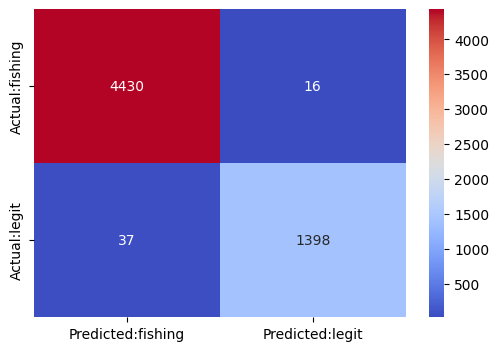

In [ ]:
# Évaluation des performances du modèle sur les données d'entraînement
print('Training Accuracy :', pipeline_ls.score(trainX, trainY))

# Évaluation des performances du modèle sur les données de test
print('Testing Accuracy :', pipeline_ls.score(testX, testY))

# Calcul de la matrice de confusion sur les données de test
con_mat = pd.DataFrame(confusion_matrix(pipeline_ls.predict(testX), testY),
            columns=['Predicted:fishing', 'Predicted:legit'],
            index=['Actual:fishing', 'Actual:legit'])

# Affichage du rapport de classification
print('\nCLASSIFICATION REPORT\n')
print(classification_report(pipeline_ls.predict(testX), testY,
                            target_names=['fishing', 'legit']))

# Affichage de la matrice de confusion sous forme de figure
print('\nCONFUSION MATRIX')
plt.figure(figsize=(6, 4))
sns.heatmap(con_mat, annot=True, fmt='d', cmap="coolwarm")

# Affichage de la figure
plt.show()

In [ ]:
import pickle


pickle.dump(pipeline_ls,open('/content/drive/MyDrive/ProjetData354/Projet1/phishingLR3.pkl','wb'))


In [ ]:
loaded_model = pickle.load(open('/content/drive/MyDrive/ProjetData354/Projet1/phishingLR3.pkl', 'rb'))
result = loaded_model.score(testX,testY)
print(result)

0.9909879272232613


In [ ]:
predict_bad = ['yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php','fazan-pacir.rs/temp/libraries/ipad','tubemoviez.exe','svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']
predict_good = ['youtube.com/','youtube.com/watch?v=qI0TQJI3vdU','retailhellunderground.com/','restorevisioncenters.com/html/technology.html']
loaded_model = pickle.load(open('/content/drive/MyDrive/ProjetData354/Projet1/phishingLR3.pkl', 'rb'))
# predict_bad = vectorizers.transform(predict_bad)
# predict_good = vectorizer.transform(predict_good)
result = loaded_model.predict(predict_bad)
result2 = loaded_model.predict(predict_good)
print(result)
print("-"*40)
print(result2)

[1 1 1 1]
----------------------------------------
[1 0 1 1]
